In [2]:
from google.colab import drive
drive.mount('/content/drive')
PROJECT = '/content/drive/MyDrive/guvi_hcl_project3'
print("PROJECT path is:", PROJECT)


Mounted at /content/drive
PROJECT path is: /content/drive/MyDrive/guvi_hcl_project3


In [3]:
!ls "{PROJECT}/data/raw"


ecom_sample_orders.csv


Category-wise Return Rate (%):
 category
Clothing          12.35
Electronics        3.65
Home & Kitchen     3.51
Sports             3.17
Beauty             3.14
Toys               2.54
Name: is_returned, dtype: float64


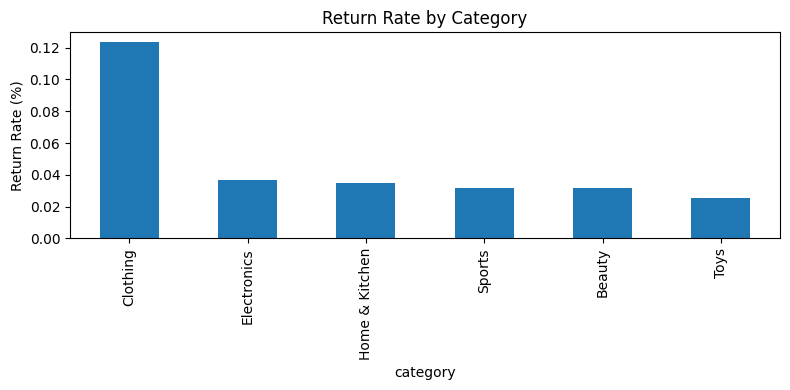

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

raw = pd.read_csv("/content/drive/MyDrive/guvi_hcl_project3/data/raw/ecom_sample_orders.csv", parse_dates=['order_date'])

cat_returns = raw.groupby('category')['is_returned'].mean().sort_values(ascending=False)
print("Category-wise Return Rate (%):\n", (cat_returns*100).round(2))

cat_returns.plot(kind='bar', figsize=(8,4), title="Return Rate by Category")
plt.ylabel("Return Rate (%)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/guvi_hcl_project3/figures/category_return_rate.png")
plt.show()


Top 10 sellers by return rate:
    seller_id  orders  return_rate
30  seller_37     152     0.098684
19  seller_27     144     0.083333
42  seller_48     169     0.082840
20  seller_28     157     0.082803
35  seller_41     154     0.077419
6   seller_15     158     0.075949
46   seller_6     150     0.073333
25  seller_32     166     0.071856
32  seller_39     157     0.070064
5   seller_14     146     0.068493


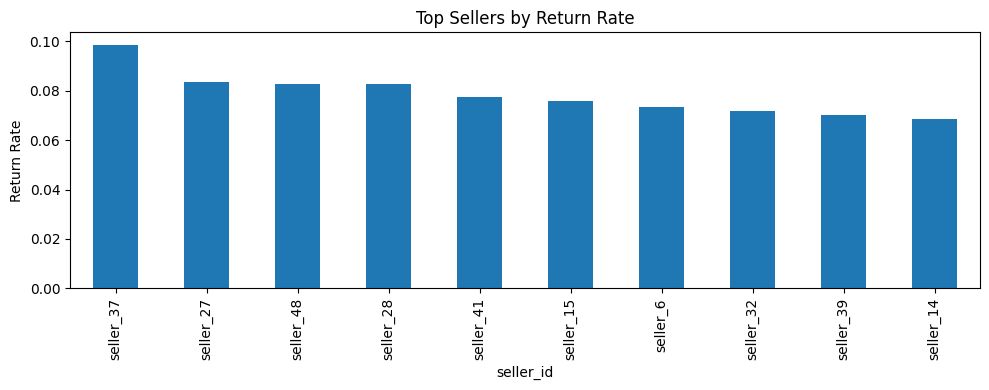

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

for col in ['order_date', 'ship_date', 'delivery_date']:
    if raw[col].dtype == 'object':
        raw[col] = pd.to_datetime(raw[col], errors='coerce')

if 'delivery_days' not in raw.columns:
    raw['delivery_days'] = (raw['delivery_date'] - raw['ship_date']).dt.days.clip(lower=0)

seller_perf = raw.groupby('seller_id').agg(
    orders=('order_id','nunique'),
    returns=('is_returned','sum'),
    return_rate=('is_returned','mean'),
    avg_delivery_days=('delivery_days','mean')
).reset_index()

top_sellers = seller_perf.sort_values('return_rate', ascending=False).head(10)
print("Top 10 sellers by return rate:")
print(top_sellers[['seller_id','orders','return_rate']])

top_sellers.plot(
    x='seller_id',
    y='return_rate',
    kind='bar',
    figsize=(10,4),
    title="Top Sellers by Return Rate",
    legend=False
)
plt.ylabel("Return Rate")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/guvi_hcl_project3/figures/top_sellers_return_rate.png")
plt.show()



📊 State-level performance:
           state  orders  avg_delivery_days  return_rate
0          Delhi    1325           5.289336     0.065623
1      Karnataka    1317           5.517763     0.056689
2    Maharashtra    1324           5.572714     0.056972
3     Tamil Nadu    1298           5.492720     0.050575
4  Uttar Pradesh    1341           5.424332     0.053412
5    West Bengal    1340           5.533729     0.048184


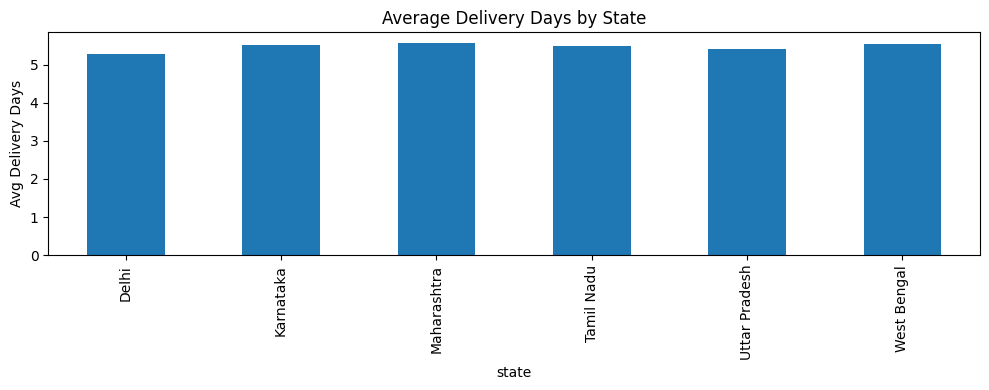

In [14]:
if 'delivery_days' not in raw.columns:
    raw['delivery_days'] = (pd.to_datetime(raw['delivery_date']) - pd.to_datetime(raw['ship_date'])).dt.days.clip(lower=0)

state_perf = raw.groupby('state').agg(
    orders=('order_id','nunique'),
    avg_delivery_days=('delivery_days','mean'),
    return_rate=('is_returned','mean')
).reset_index()

print("📊 State-level performance:")
print(state_perf)

state_perf.plot(
    x='state',
    y='avg_delivery_days',
    kind='bar',
    figsize=(10,4),
    title="Average Delivery Days by State",
    legend=False
)
plt.ylabel("Avg Delivery Days")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/guvi_hcl_project3/figures/state_delivery_days.png")
plt.show()


In [15]:
orders = pd.read_csv("/content/drive/MyDrive/guvi_hcl_project3/data/processed/fact_orders.csv", parse_dates=['order_date'])
orders = orders.sort_values(['customer_id','order_date'])

orders['first_order_date'] = orders.groupby('customer_id')['order_date'].transform('min')
orders['is_repeat'] = (orders['order_date'] > orders['first_order_date']).astype(int)

repeat_summary = orders.groupby('is_repeat').agg(
    orders=('order_id','count'),
    return_rate=('is_returned','mean'),
    on_time_pct=('on_time','mean'),
    avg_order_value=('order_gmv','mean')
).reset_index()

repeat_summary['is_repeat'] = repeat_summary['is_repeat'].map({0:'New',1:'Repeat'})
print("📊 Repeat vs New customer stats:")
print(repeat_summary)


📊 Repeat vs New customer stats:
  is_repeat  orders  return_rate  on_time_pct  avg_order_value
0       New    5511     0.054074     0.503720      4833.088654
1    Repeat    2489     0.057855     0.494174      4831.679068
